# Causal Explanations in Models with Continuous Random Variables

The **Explainable Reasoning with Chirho** package aims to provide a unified, principled approach to computations of causal explanations. We showed in an earlier [tutorial](https://basisresearch.github.io/chirho/explainable_categorical.html) how Chirho provides a handler `SearchForExplanation` to carry out the program transformations needed to compute causal queries and explanations. We specifically used discrete models and in this tutorial, we extend the usage of `SearchForExplanation` to causal models with continuous random variables.

We take an epidemiological dynamical system model (described in more detail in this [tutorial](https://basisresearch.github.io/chirho/dynamical_intro.html)) and show how but-for analysis is not enough to derive conclusions about effects of different policies during a pandemic. We, then, show how various causal explanation queries can be computed using `SearchForExplanation` and in-built inference algorithms. We also demonstrate how more fine grained analysis can be done by post-processing the samples. 

## Outline

- Setup
- Bayesian epidemiological SIR model with Policies
    - SIR model
    - Bayesian SIR model
    - Baysian SIR model with Policies
- But-for analysis for Bayesian SIR model
- Causal Explanations using `SearchForExplanation`
- Fine-grained analysis for `overshoot` using sample traces


## Setup

We first install the required dependencies for this example: PyTorch, Pyro, Chirho and some auxiliary variables.


In [209]:
import numbers
import os
from typing import Tuple, TypeVar, Union, Optional, Callable
import math

import matplotlib.pyplot as plt
import pandas as pd
import pyro.distributions as dist
from pyro.distributions import constraints
import seaborn as sns
import torch
from pyro.infer import Predictive

import pyro
from chirho.counterfactual.handlers.counterfactual import \
    MultiWorldCounterfactual
from chirho.dynamical.handlers.interruption import StaticEvent
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.handlers.trajectory import LogTrajectory
from chirho.dynamical.ops import Dynamics, State, on, simulate
from chirho.explainable.handlers import SearchForExplanation
from chirho.explainable.handlers.components import ExtractSupports
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.ops import Intervention, intervene
from chirho.observational.handlers import condition

R = Union[numbers.Real, torch.Tensor]
S = TypeVar("S")
T = TypeVar("T")


sns.set_style("white")

seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

smoke_test = "CI" in os.environ
num_samples = 10 if smoke_test else 300
exp_plate_size = 10 if smoke_test else 2000

## Bayesian Epidemiological SIR model with Policies

Now, we build the epidemiological SIR model, one step at a time. We first encode deterministic SIR (Susceptible, Infected, Recovered) dynamics. Then we add uncertainty to the parameters that govern these dynamics, namely $\beta$ and $\gamma$. These parameters have been described in much detail in the [dynamical systems tutorial](https://basisresearch.github.io/chirho/dynamical_intro.html). We then integrate the resulting model into another model that describes the policy mechanisms such as imposing lockdown and masking restrictions.

### SIR Model and Simulation

In [210]:
# dS = - beta . SI
# dI = beta * SI - gamma * I
# dR = gamma * I

class SIRDynamics(pyro.nn.PyroModule):
    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    def forward(self, X: State[torch.Tensor]):
        dX: State[torch.Tensor] = dict()
        dX["S"] = -self.beta * X["S"] * X["I"]
        dX["I"] = self.beta * X["S"] * X["I"] - self.gamma * X["I"]
        dX["R"] = self.gamma * X["I"]

        return dX


# TODO add running overshoot to states?
# beta = (1 - l) beta0

class SIRDynamicsLockdown(SIRDynamics):
    def __init__(self, beta0, gamma):
        super().__init__(beta0, gamma)
        self.beta0 = beta0

    def forward(self, X: State[torch.Tensor]):
        self.beta = (1 - X["l"]) * self.beta0
        dX = super().forward(X)
        dX["l"] = torch.zeros_like(X["l"])
        return dX

In [211]:
# Computing overshoot in a simple SIR model

init_state = dict(S=torch.tensor(99.0), I=torch.tensor(1.0), R=torch.tensor(0.0))
start_time = torch.tensor(0.0)
end_time = torch.tensor(12.0)
step_size = torch.tensor(0.1)
logging_times = torch.arange(start_time, end_time, step_size)
init_state_lockdown = dict(**init_state, l=torch.tensor(0.0))

# We now simulate from the SIR model
beta_true = torch.tensor([0.03])
gamma_true = torch.tensor([0.5])
sir_true = SIRDynamics(beta_true, gamma_true)
with TorchDiffEq(), LogTrajectory(logging_times) as lt:
    simulate(sir_true, init_state, start_time, end_time)

sir_true_traj = lt.trajectory


def get_overshoot(trajectory):
    t_max = torch.argmax(trajectory["I"].squeeze())
    S_peak = torch.max(trajectory["S"].squeeze()[t_max]) / 100
    S_final = trajectory["S"].squeeze()[-1] / 100
    return (S_peak - S_final).item()


print(get_overshoot(sir_true_traj))

0.15116800367832184


The number $0.15$ is the overshoot you get if $\beta = 0.03, \gamma = 0.5$. This value is observed by simulating the SIR dynamics model with these values and calculate overshoot directly. Now one can add uncertainty to the parameters of $\beta, \gamma$ and get a Bayesian SIR model.

### Bayesian SIR model

In Bayesian SIR model, we specifically add uncertainty to $\beta$ and $\gamma$ by inducing $\beta$ to be drawn from the distribution Beta(18, 600), and $\gamma$ to be drawn from the distribution Beta(1600, 1600). 

In [212]:
# Defining a Bayesian SIR model where we have priors over beta and gamma distributions

def bayesian_sir(base_model=SIRDynamics) -> Dynamics[torch.Tensor]:
    beta = pyro.sample("beta", dist.Beta(18, 600))
    gamma = pyro.sample("gamma", dist.Beta(1600, 1600))
    sir = base_model(beta, gamma)
    return sir


def simulated_bayesian_sir(
    init_state, start_time, logging_times, base_model=SIRDynamics
) -> State[torch.Tensor]:
    sir = bayesian_sir(base_model)

    with TorchDiffEq(), LogTrajectory(logging_times, is_traced=True) as lt:
        simulate(sir, init_state, start_time, logging_times[-1])
    return lt.trajectory

### Bayesian SIR model with Policies

Now we integrate the Bayesian SIR model with the effect of different policies. We consider two possible policies, lockdown and masking, where each can be implemented with $50\%$ probability. We encode their efficiencies which further affect the Bayesian SIR model via a utility function (`MaskedStaticIntervention`) defiend below. The model also computes `overshoot` and `os_too_high` indicating the overshoot and if it was too high for further analysis.



In [213]:
# Defining intervention

def MaskedStaticIntervention(time: R, intervention: Intervention[State[T]]):

    @on(StaticEvent(time))
    def callback(
        dynamics: Dynamics[T], state: State[T]
    ) -> Tuple[Dynamics[T], State[T]]:

        with pyro.poutine.block():
            return dynamics, intervene(state, intervention)

    return callback

In [214]:
# Defining the policy model

overshoot_threshold = 20
lockdown_time = torch.tensor(1.0)
mask_time = torch.tensor(1.5)


def policy_model():

    lockdown = pyro.sample("lockdown", dist.Bernoulli(torch.tensor(0.5)))
    mask = pyro.sample("mask", dist.Bernoulli(torch.tensor(0.5)))

    lockdown_efficiency = pyro.deterministic(
        "lockdown_efficiency", torch.tensor(0.6) * lockdown, event_dim=0
    )

    mask_efficiency = pyro.deterministic(
        "mask_efficiency", (0.1 * lockdown + 0.45 * (1 - lockdown)) * mask, event_dim=0
    )

    joint_efficiency = pyro.deterministic(
        "joint_efficiency",
        torch.clamp(lockdown_efficiency + mask_efficiency, 0, 0.95),
        event_dim=0,
    )

    lockdown_sir = bayesian_sir(SIRDynamicsLockdown)
    with LogTrajectory(logging_times, is_traced=True) as lt:
        with TorchDiffEq():
            with MaskedStaticIntervention(lockdown_time, dict(l=lockdown_efficiency)):
                with MaskedStaticIntervention(mask_time, dict(l=joint_efficiency)):
                    simulate(
                        lockdown_sir, init_state_lockdown, start_time, logging_times[-1]
                    )

    trajectory = lt.trajectory

    t_max = torch.max(trajectory["I"], dim=-1).indices
    S_peaks = pyro.ops.indexing.Vindex(trajectory["S"])[..., t_max]
    overshoot = pyro.deterministic(
        "overshoot", S_peaks - trajectory["S"][..., -1], event_dim=0
    )
    os_too_high = pyro.deterministic(
        "os_too_high",
        (overshoot > overshoot_threshold).clone().detach().float(),
        event_dim=0,
    )

    return overshoot, os_too_high

## But-for Analysis with Bayesian SIR model with Policies

Now that we have the Bayesian SIR model with Policies, we can do but-for analysis to idenitfy which one of the policies cause overshoot to be too high. To perform but-for analysis, we investigate the following four scenarios:
1. Model where non of the policies were applied
2. Model where both lockdown and masking were enforced
3. Model where only masking was imposed
4. Model where only lockdown was imposed

We create these four models by conditioning on the policies being imposed as required. The models obtained are similar to intervened models since the variables `lockdown` and `mask` do not have any variables upstream to them.

In [312]:
# conditioning (as opposed to intervening) is sufficient for
# propagating the changes, as the decisions are upstream from ds

# Doing but-for analysis

# no interventions
num_samples = 10000
policy_model_none = condition(
    policy_model, {"lockdown": torch.tensor(0.0), "mask": torch.tensor(0.0)}
)
unintervened_predictive = Predictive(
    policy_model_none, num_samples=num_samples, parallel=True
)
unintervened_samples = unintervened_predictive()

# both interventions
policy_model_all = condition(
    policy_model, {"lockdown": torch.tensor(1.0), "mask": torch.tensor(1.0)}
)
intervened_predictive = Predictive(
    policy_model_all, num_samples=num_samples, parallel=True
)
intervened_samples = intervened_predictive()

policy_model_mask = condition(
    policy_model, {"lockdown": torch.tensor(0.0), "mask": torch.tensor(1.0)}
)
mask_predictive = Predictive(policy_model_mask, num_samples=num_samples, parallel=True)
mask_samples = mask_predictive()

policy_model_lockdown = condition(
    policy_model, {"lockdown": torch.tensor(1.0), "mask": torch.tensor(0.0)}
)
lockdown_predictive = Predictive(
    policy_model_lockdown, num_samples=num_samples, parallel=True
)
lockdown_samples = lockdown_predictive()

predictive = Predictive(
    policy_model, num_samples=num_samples, parallel=True
)
samples = predictive()

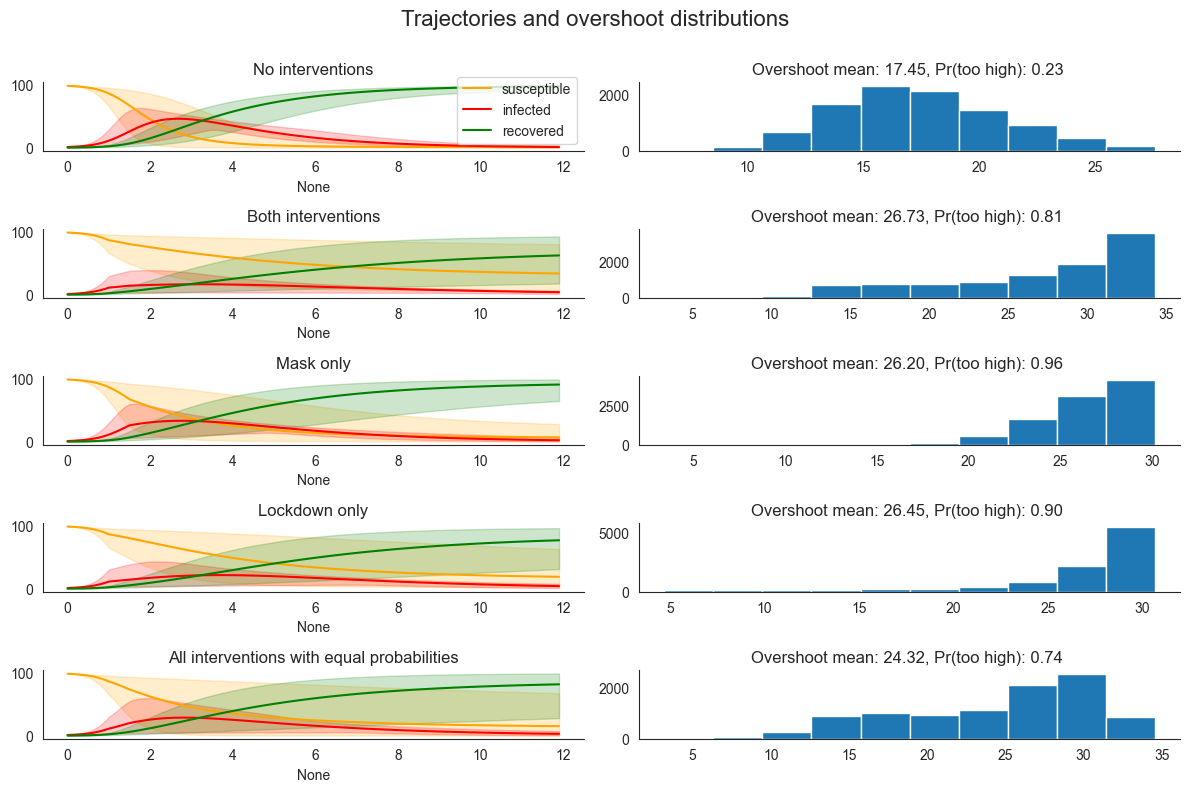

In [336]:
def add_pred_to_plot(preds, axs, coords, color, label):
    sns.lineplot(
        x=logging_times,
        y=preds.mean(dim=0).squeeze().tolist(),
        ax=axs[coords],
        label=label,
        color=color,
    )
    axs[coords].fill_between(
        logging_times,
        torch.quantile(preds, 0.025, dim=0).squeeze(),
        torch.quantile(preds, 0.975, dim=0).squeeze(),
        alpha=0.2,
        color=color,
    )


fig, axs = plt.subplots(5, 2, figsize=(12, 7.5))

colors = ["orange", "red", "green"]

add_pred_to_plot(
    unintervened_samples["S"], axs, coords=(0, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    unintervened_samples["I"], axs, coords=(0, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    unintervened_samples["R"], axs, coords=(0, 0), color=colors[2], label="recovered"
)

axs[0, 1].hist(unintervened_samples["overshoot"].squeeze())
axs[0, 0].set_title("No interventions")
axs[0, 1].set_title(
    f"Overshoot mean: {unintervened_samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {unintervened_samples['os_too_high'].squeeze().float().mean().item():.2f} "
)


add_pred_to_plot(
    intervened_samples["S"], axs, coords=(1, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    intervened_samples["I"], axs, coords=(1, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    intervened_samples["R"], axs, coords=(1, 0), color=colors[2], label="recovered"
)
axs[1, 0].set_title("Both interventions")
axs[1, 0].legend_.remove()


axs[1, 1].hist(intervened_samples["overshoot"].squeeze())
axs[1, 1].set_title(
    f"Overshoot mean: {intervened_samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {intervened_samples['os_too_high'].squeeze().float().mean().item():.2f} "
)


add_pred_to_plot(
    mask_samples["S"], axs, coords=(2, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    mask_samples["I"], axs, coords=(2, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    mask_samples["R"], axs, coords=(2, 0), color=colors[2], label="recovered"
)
axs[2, 0].set_title("Mask only")
axs[2, 0].legend_.remove()

axs[2, 1].hist(mask_samples["overshoot"].squeeze())
axs[2, 1].set_title(
    f"Overshoot mean: {mask_samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {mask_samples['os_too_high'].squeeze().float().mean().item():.2f} "
)

add_pred_to_plot(
    lockdown_samples["S"], axs, coords=(3, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    lockdown_samples["I"], axs, coords=(3, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    lockdown_samples["R"], axs, coords=(3, 0), color=colors[2], label="recovered"
)
axs[3, 0].set_title("Lockdown only")
axs[3, 0].legend_.remove()

axs[3, 1].hist(lockdown_samples["overshoot"].squeeze())
axs[3, 1].set_title(
    f"Overshoot mean: {lockdown_samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {lockdown_samples['os_too_high'].squeeze().float().mean().item():.2f} "
)

add_pred_to_plot(
    samples["S"], axs, coords=(4, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    samples["I"], axs, coords=(4, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    samples["R"], axs, coords=(4, 0), color=colors[2], label="recovered"
)
axs[4, 0].set_title("All interventions with equal probabilities")
axs[4, 0].legend_.remove()

axs[4, 1].hist(samples["overshoot"].squeeze())
axs[4, 1].set_title(
    f"Overshoot mean: {samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {samples['os_too_high'].squeeze().float().mean().item():.2f} "
)


fig.tight_layout()
fig.suptitle("Trajectories and overshoot distributions", fontsize=16, y=1.05)
sns.despine()

plt.savefig("counterfactual_sir.png")

The plots above show what happens in the four different scenarios. We observe that in the model where none of the policies were imposed, there was very low probability of high overshoot $0.24$. On the other hand, when both policies were imposed, the probability of high overshoot was relatively higher $0.81$. 

To identify, which one of `lockdown` and `mask` is the cause, we analyze the models where only one of the policies were imposed. It seems that when only one of the policies were imposed, the probability of high overshoot seems to be even higher $0.96$ and $0.9$. This indicates that both `lockdown` and `mask` were essentially helping in keeping the overshoot low but we know that is not true (as evident from the first two plots).

So, what these plots show is that there is a need of a more fine grained analysis where we not only control the variables being intervened on (that is, policies), we also control on keeping part of the context (that is, other variables in the model) fixed. In the next section, we show how this analysis can be carried out with the help of `SearchForExplanation`.

## Causal Explanations using `SearchForExplanation`

We first setup a function for performing importance sampling through the model that returns cumulative log probabilities of the samples, sample traces, handler for multiworld counterfactual reasoning and log probabilities. We use these objects later in the code to subselect the samples.

In [245]:
def importance_infer(
    model: Optional[Callable] = None, *, num_samples: int
):
    
    if model is None:
        return lambda m: importance_infer(m, num_samples=num_samples)

    def _wrapped_model(
        *args,
        **kwargs
    ):

        guide = pyro.poutine.block(hide_fn=lambda msg: msg["is_observed"])(model)

        max_plate_nesting = 9  # TODO guess

        with pyro.poutine.block(), MultiWorldCounterfactual() as mwc_imp:
            log_weights, importance_tr, _ = pyro.infer.importance.vectorized_importance_weights(
                model,
                guide,
                *args,
                num_samples=num_samples,
                max_plate_nesting=max_plate_nesting,
                normalized=False,
                **kwargs
            )

        return torch.logsumexp(log_weights, dim=0) - math.log(num_samples), importance_tr, mwc_imp, log_weights

    return _wrapped_model

Then, we setup the query as follows:
1. `supports`: We extract supports of the model using `ExtractSupports` and enrich it with additional information of `os_too_high` being a Boolean.
2. `antecedents`: We have put `lockdown=1` and `mask=1` as possible causes.
3. `alternatives`: We provide `lockdown=0` and `mask=0` as alternative values.
4. `witnesses`: We include `mask_efficiency` and `lockdown_efficiency` as candidates to be included in the context to be kept fixed.
5. `consequents`: We put `os_too_high=1` as the outcome we wish to analyze the causes for.
6. `antecedent_bias`, `witness_bias`, `consequent_scale`: We set these parameters to have equal probabilities of choosing causes and preferring minimal witness sets. Please refer to the documentation of `SearchForExplanation` for more details.

In [354]:
with ExtractSupports() as s:
    policy_model()

supports = s.supports
supports["os_too_high"] = constraints.independent(base_constraint=constraints.boolean, reinterpreted_batch_ndims=0)

query = SearchForExplanation(
            supports=supports,
            alternatives={"lockdown": torch.tensor(0.0), "mask": torch.tensor(0.0)},
            antecedents={"lockdown": torch.tensor(1.0), "mask": torch.tensor(1.0)},
            antecedent_bias=0.0,
            witnesses={key: s.supports[key] for key in ["lockdown_efficiency", "mask_efficiency"]},
            consequents={"os_too_high": torch.tensor(1.0)},
            consequent_scale=1e-8,
            witness_bias=0.2,
        )(policy_model #it was policy_model_all earlier)
        )

logp, importance_tr, mwc_imp, log_weights = importance_infer(num_samples=10000)(query)()
print(torch.exp(logp))

tensor(0.1309)


Now that we have setup the query and drawn 10000 samples from it, we can analyze the samples and their log probabilities to compute queries of interest. We first compute the probabilities that different sets of antecedent candidates have causal effect over `os_too_high`.

In [357]:
def compute_prob(trace, log_weights, mask):
    mask_intervened = torch.ones(trace.nodes["__cause____antecedent_lockdown"]["value"].shape).bool()
    for i, v in mask.items():
        mask_intervened &= (trace.nodes[i]["value"] == v)
    print(mask, (torch.sum(torch.exp(log_weights) * mask_intervened.squeeze()) / mask_intervened.float().sum()).item())

In [358]:
compute_prob(importance_tr, log_weights, {"__cause____antecedent_lockdown": 0, "__cause____antecedent_mask": 0})
compute_prob(importance_tr, log_weights, {"__cause____antecedent_lockdown": 0, "__cause____antecedent_mask": 1})
compute_prob(importance_tr, log_weights, {"__cause____antecedent_lockdown": 1, "__cause____antecedent_mask": 0})
compute_prob(importance_tr, log_weights, {"__cause____antecedent_lockdown": 1, "__cause____antecedent_mask": 1})

{'__cause____antecedent_lockdown': 0, '__cause____antecedent_mask': 0} 0.20220299065113068
{'__cause____antecedent_lockdown': 0, '__cause____antecedent_mask': 1} 0.2057761698961258
{'__cause____antecedent_lockdown': 1, '__cause____antecedent_mask': 0} 0.11375554651021957
{'__cause____antecedent_lockdown': 1, '__cause____antecedent_mask': 1} 2.610623717202998e-09


Note that one can also compute above queries by giving specific parameters to `SearchForExplanation` instead of subselecting the samples as we did in the tutorial for explainable module for models with categorical variables.

Also, we use the log probabilities above to identify whether a particular combination of intervening nodes and context nodes have causal power or not. One can also obatin these results by explictly analyzing the sample trace as we do in the next section.

We can also compute degree of responsibilities assigned to both lockdown and mask as follows:

In [361]:
print("Degree of responsibility for lockdown: ")
compute_prob(importance_tr, log_weights, {"__cause____antecedent_lockdown": 0})
print()

print("Degree of responsibility for mask: ")
compute_prob(importance_tr, log_weights, {"__cause____antecedent_mask": 0})

Degree of responsibility for lockdown: 
{'__cause____antecedent_lockdown': 0} 0.20397219061851501

Degree of responsibility for mask: 
{'__cause____antecedent_mask': 0} 0.15853415429592133


Further notebook is still work in progress. Some questions I had:
1. Normalization of degree of responsibility is not super clear to me that why we would want to do that.
2. The plots below are updated with `policy_model` instead of `policy_model_all`.

# Fine grained analysis of overshoot variables

## Factual plot

In [301]:
def histogram_data(trace, mwc, masks, world):
    with mwc:
        data_to_plot = gather(trace.nodes["overshoot"]["value"], IndexSet(**{"lockdown": {world}, "mask": {world}}))

        mask_tensor = torch.ones(importance_tr.nodes["__cause____antecedent_mask"]["value"].shape).bool()
        for key, val in masks.items():
            mask_tensor = mask_tensor & (trace.nodes[key]["value"] == val)
        data_to_plot = data_to_plot.squeeze()[torch.nonzero(mask_tensor.squeeze())]

        os_too_high = (gather(trace.nodes["os_too_high"]["value"], IndexSet(**{"lockdown": {world}, "mask": {world}})))
        os_too_high = os_too_high.squeeze()[torch.nonzero(mask_tensor.squeeze())]

        overshoot_mean = data_to_plot.mean()
        os_too_high_mean = os_too_high.mean()

    hist, bin_edges = torch.histogram(data_to_plot, bins = 28, range=(5, 40), density=True)
    return hist, bin_edges, overshoot_mean, os_too_high_mean


In [302]:
hist_fact, bin_edges, os_fact, oth_fact = histogram_data(importance_tr, mwc_imp, {}, 0)
hist_mask, bin_edges, os_mask, oth_mask = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 0, "__cause____antecedent_lockdown": 1, "__cause____witness_mask_efficiency": 0}, 1)
hist_lockdown, bin_edges, os_lockdown, oth_lockdown = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 1, "__cause____antecedent_lockdown": 0, "__cause____witness_lockdown_efficiency": 0}, 1)

Overshoot mean
factual:  24.13526153564453  counterfactual mask:  21.76302719116211  counterfactual lockdown:  20.221193313598633
Probability of overshoot being high
factual:  0.722599983215332  counterfactual mask:  0.5667539238929749  counterfactual lockdown:  0.47914034128189087


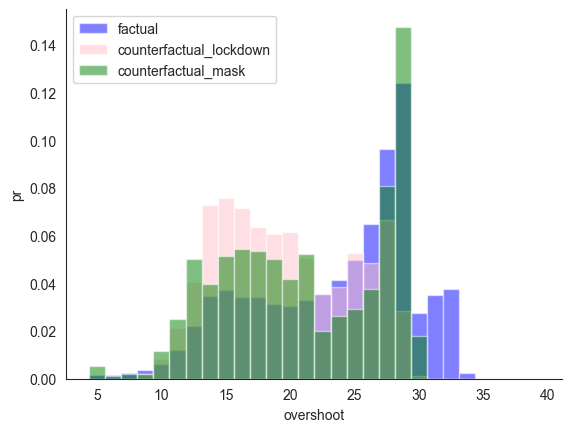

In [366]:
plt.bar(bin_edges[:28].tolist(), hist_fact, align='center', width = 35/28, alpha = 0.5, color='blue')
plt.bar(bin_edges[:28].tolist(), hist_lockdown, align='center', width = 35/28, alpha = 0.5, color='pink')
plt.bar(bin_edges[:28].tolist(), hist_mask, align='center', width = 35/28, alpha = 0.5, color='green')
plt.legend(["factual", "counterfactual_lockdown", "counterfactual_mask"])
plt.ylabel("pr")
plt.xlabel("overshoot")
sns.despine()

print("Overshoot mean")
print("factual: ", os_fact.item(), " counterfactual mask: ", os_mask.item(), " counterfactual lockdown: ", os_lockdown.item())

print("Probability of overshoot being high")
print("factual: ", oth_fact.item(), " counterfactual mask: ", oth_mask.item(), " counterfactual lockdown: ", oth_lockdown.item())

# Sufficiency worlds

In [292]:
hist_fact, bin_edges, os_fact, oth_fact = histogram_data(importance_tr, mwc_imp, {}, 0)
hist_mask, bin_edges, os_mask, oth_mask = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 0, "__cause____antecedent_lockdown": 1, "__cause____witness_mask_efficiency": 0}, 2)
hist_lockdown, bin_edges, os_lockdown, oth_lockdown = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 1, "__cause____antecedent_lockdown": 0, "__cause____witness_lockdown_efficiency": 0}, 2)

Overshoot mean
factual:  24.143041610717773  counterfactual mask:  26.505809783935547  counterfactual lockdown:  22.47197723388672
Probability of overshoot being high
factual:  0.7235000133514404  counterfactual mask:  0.8883248567581177  counterfactual lockdown:  0.7112860679626465


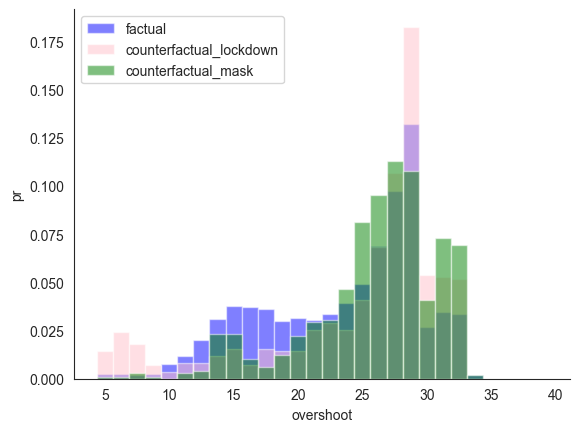

In [293]:
plt.bar(bin_edges[:28].tolist(), hist_fact, align='center', width = 35/28, alpha = 0.5, color='blue')
plt.bar(bin_edges[:28].tolist(), hist_lockdown, align='center', width = 35/28, alpha = 0.5, color='pink')
plt.bar(bin_edges[:28].tolist(), hist_mask, align='center', width = 35/28, alpha = 0.5, color='green')
plt.legend(["factual", "counterfactual_lockdown", "counterfactual_mask"])
plt.ylabel("pr")
plt.xlabel("overshoot")
sns.despine()

print("Overshoot mean")
print("factual: ", os_fact.item(), " counterfactual mask: ", os_mask.item(), " counterfactual lockdown: ", os_lockdown.item())

print("Probability of overshoot being high")
print("factual: ", oth_fact.item(), " counterfactual mask: ", oth_mask.item(), " counterfactual lockdown: ", oth_lockdown.item())

# Counterfactual lockdown by mask efficiency contexts

In [294]:
hist_lockdown_fix, bin_edges, os_lockdown_fix, oth_lockdown_fix = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 1, "__cause____antecedent_lockdown": 0, "__cause____witness_lockdown_efficiency": 0, "__cause____witness_mask_efficiency": 1}, 1)
hist_lockdown_notfix, bin_edges, os_lockdown_notfix, oth_lockdown_notfix = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 1, "__cause____antecedent_lockdown": 0, "__cause____witness_lockdown_efficiency": 0, "__cause____witness_mask_efficiency": 0}, 1)

Overshoot mean
mask_efficiency fixed:  19.993305206298828  mask_efficiency not fixed:  21.670305252075195
Probability of overshoot being high
mask_efficiency fixed:  0.4733840227127075  mask_efficiency not fixed:  0.5932203531265259


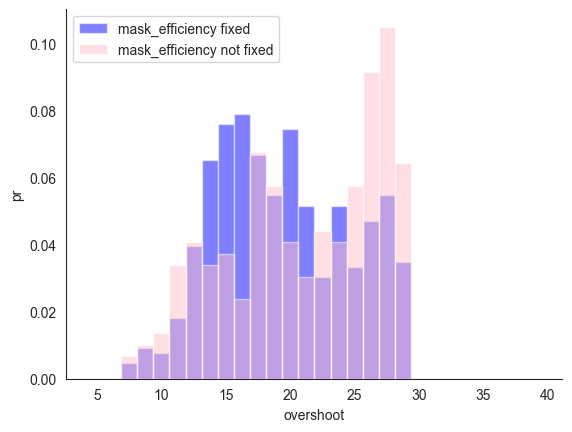

In [295]:
plt.bar(bin_edges[:28].tolist(), hist_lockdown_fix, align='center', width = 35/28, alpha = 0.5, color='blue')
plt.bar(bin_edges[:28].tolist(), hist_lockdown_notfix, align='center', width = 35/28, alpha = 0.5, color='pink')
plt.legend(["mask_efficiency fixed", "mask_efficiency not fixed"])
plt.ylabel("pr")
plt.xlabel("overshoot")
sns.despine()

print("Overshoot mean")
print("mask_efficiency fixed: ", os_lockdown_fix.item(), " mask_efficiency not fixed: ", os_lockdown_notfix.item())

print("Probability of overshoot being high")
print("mask_efficiency fixed: ", oth_lockdown_fix.item(), " mask_efficiency not fixed: ", oth_lockdown_notfix.item())

# Counterfactual mask by lockdown efficiency contexts

In [296]:
hist_mask_fix, bin_edges, os_mask_fix, oth_mask_fix = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 0, "__cause____antecedent_lockdown": 1, "__cause____witness_mask_efficiency": 0, "__cause____witness_lockdown_efficiency": 1}, 1)
hist_mask_notfix, bin_edges, os_mask_notfix, oth_mask_notfix = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 0, "__cause____antecedent_lockdown": 1, "__cause____witness_mask_efficiency": 0, "__cause____witness_lockdown_efficiency": 0}, 1)

Overshoot mean
lockdown_efficiency fixed:  21.956771850585938  lockdown_efficiency not fixed:  21.55644989013672
Probability of overshoot being high
lockdown_efficiency fixed:  0.5478423833847046  lockdown_efficiency not fixed:  0.5529412031173706


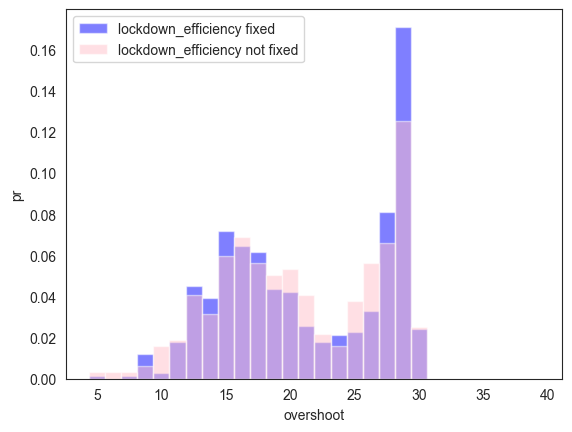

In [297]:
plt.bar(bin_edges[:28].tolist(), hist_mask_fix, align='center', width = 35/28, alpha = 0.5, color='blue')
plt.bar(bin_edges[:28].tolist(), hist_mask_notfix, align='center', width = 35/28, alpha = 0.5, color='pink')
plt.legend(["lockdown_efficiency fixed", "lockdown_efficiency not fixed"])
plt.ylabel("pr")
plt.xlabel("overshoot")
sns.despine

print("Overshoot mean")
print("lockdown_efficiency fixed: ", os_mask_fix.item(), " lockdown_efficiency not fixed: ", os_mask_notfix.item())

print("Probability of overshoot being high")
print("lockdown_efficiency fixed: ", oth_mask_fix.item(), " lockdown_efficiency not fixed: ", oth_mask_notfix.item())